### Technical report on model's performance and training

This notebook contains training details and evaluation of the dummy home-trained model for image captioning task.

#### 1. Dataset

The dataset used in this project is COCO Captions, which comprises 120,000 images, with each image accompanied by 5 captions. The development set consists of 5,000 images, each having 5 captions as well. In total, the models were trained on over 600,000 captions. Dataset was cleaned and preprocessed. No further data augmentation was applied.

#### 2. Model

The model consists of two parts: an Encoder and a Decoder. The Encoder is a ViT-B @224 model (~87 million params) with frozen weights pretrained on ImageNet-22K. It has been fine-tuned on ImageNet-1K and achieved a classification accuracy of around 85%. The Decoder, responsible for generating captions, is a GPT-style model initialized with extracted features from the Encoder.

Several models with different numbers of parameters were trained, and the best one was chosen based on a SacreBLEU score. The table below presents the architecture of the trained model.

| Parameter                | Value   |
|--------------------------|---------|
| seq_len                  | 40      |
| vocab_size               | 10,000  |
| proj_dim                 | 768     |
| intermidiate_dim         | 384     |
| embed_dim                | 256     |
| nhead                    | 4       |
| hidden_layer_multiplier  | 4       |
| activation               | gelu    |
| num_layers               | 6       |

<br>

Training was conducted on a GTX 1660, taking approximately 1.5 hours for the 12 million parameter model mentioned earlier. The table below displays the specific hyperparameters employed during the training process. Despite label smoothing leading to an increase in the model's loss and perplexity, it had a positive impact on the SacreBLEU score. Additionally, a cosine learning rate scheduler was implemented, with a minimum learning rate of 0 reached by the end of the 5th epoch. The model parameters were divided into two groups: LayerNorm, Biases, and Embeddings, which were not subjected to weight decay, while other parameters had a weight decay of 0.1. 

| Hyperparameter    | Value       |
|-------------------|-------------|
| dropout           | 0.1         |
| learning_rate     | 0.003       |
| betas             | [0.9, 0.999]|
| weight_decay      | 0.1         |
| label_smoothing   | 0.1         |
| batch_size        | 128         |
| max_epochs        | 5           |

#### 3. Results

Different decoding strategies were incorporated, including greedy search, top-k and top-p sampling, beam search, and contrastive search. The best-trained model achieved a SacreBLEU score of 26.70 using vanilla greedy search. Greedy search was chosen for scoring due to the high computational requirements of other methods. Below are 10 examples with generated captions using beam search (with beam size 5), as it provided the most coherent results.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import sys
sys.path.append('D:/projects/Torch/Image Captioning vol.2')
from scripts.captioner import ImageCaptioner

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Triton is not available, some optimizations will not be enabled.
This is just a warning: No module named 'triton'
Triton is not available, FusedMLP will not be enabled.
Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


In [3]:
def display_images(directory, model, max_imgs=10, beam_size=1, top_k=0, top_p=0, temperature=1, alpha=0, seed=2018):
    np.random.seed(seed)
    image_files = [file for file in os.listdir(directory) if file.endswith((".jpg", ".png"))]
    image_files = np.random.choice(image_files, max_imgs, replace=False)

    rows = (len(image_files) + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(10, 5 * rows))
    axes = axes.ravel()

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        captions = model.generate_caption(
            image, 
            beam_size=beam_size, 
            top_k=top_k, 
            top_p=top_p, 
            temperature=temperature, 
            alpha=alpha
        ).capitalize()
        resized_image = image.resize((224, 224))
        axes[i].imshow(resized_image)
        axes[i].set_title(captions)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

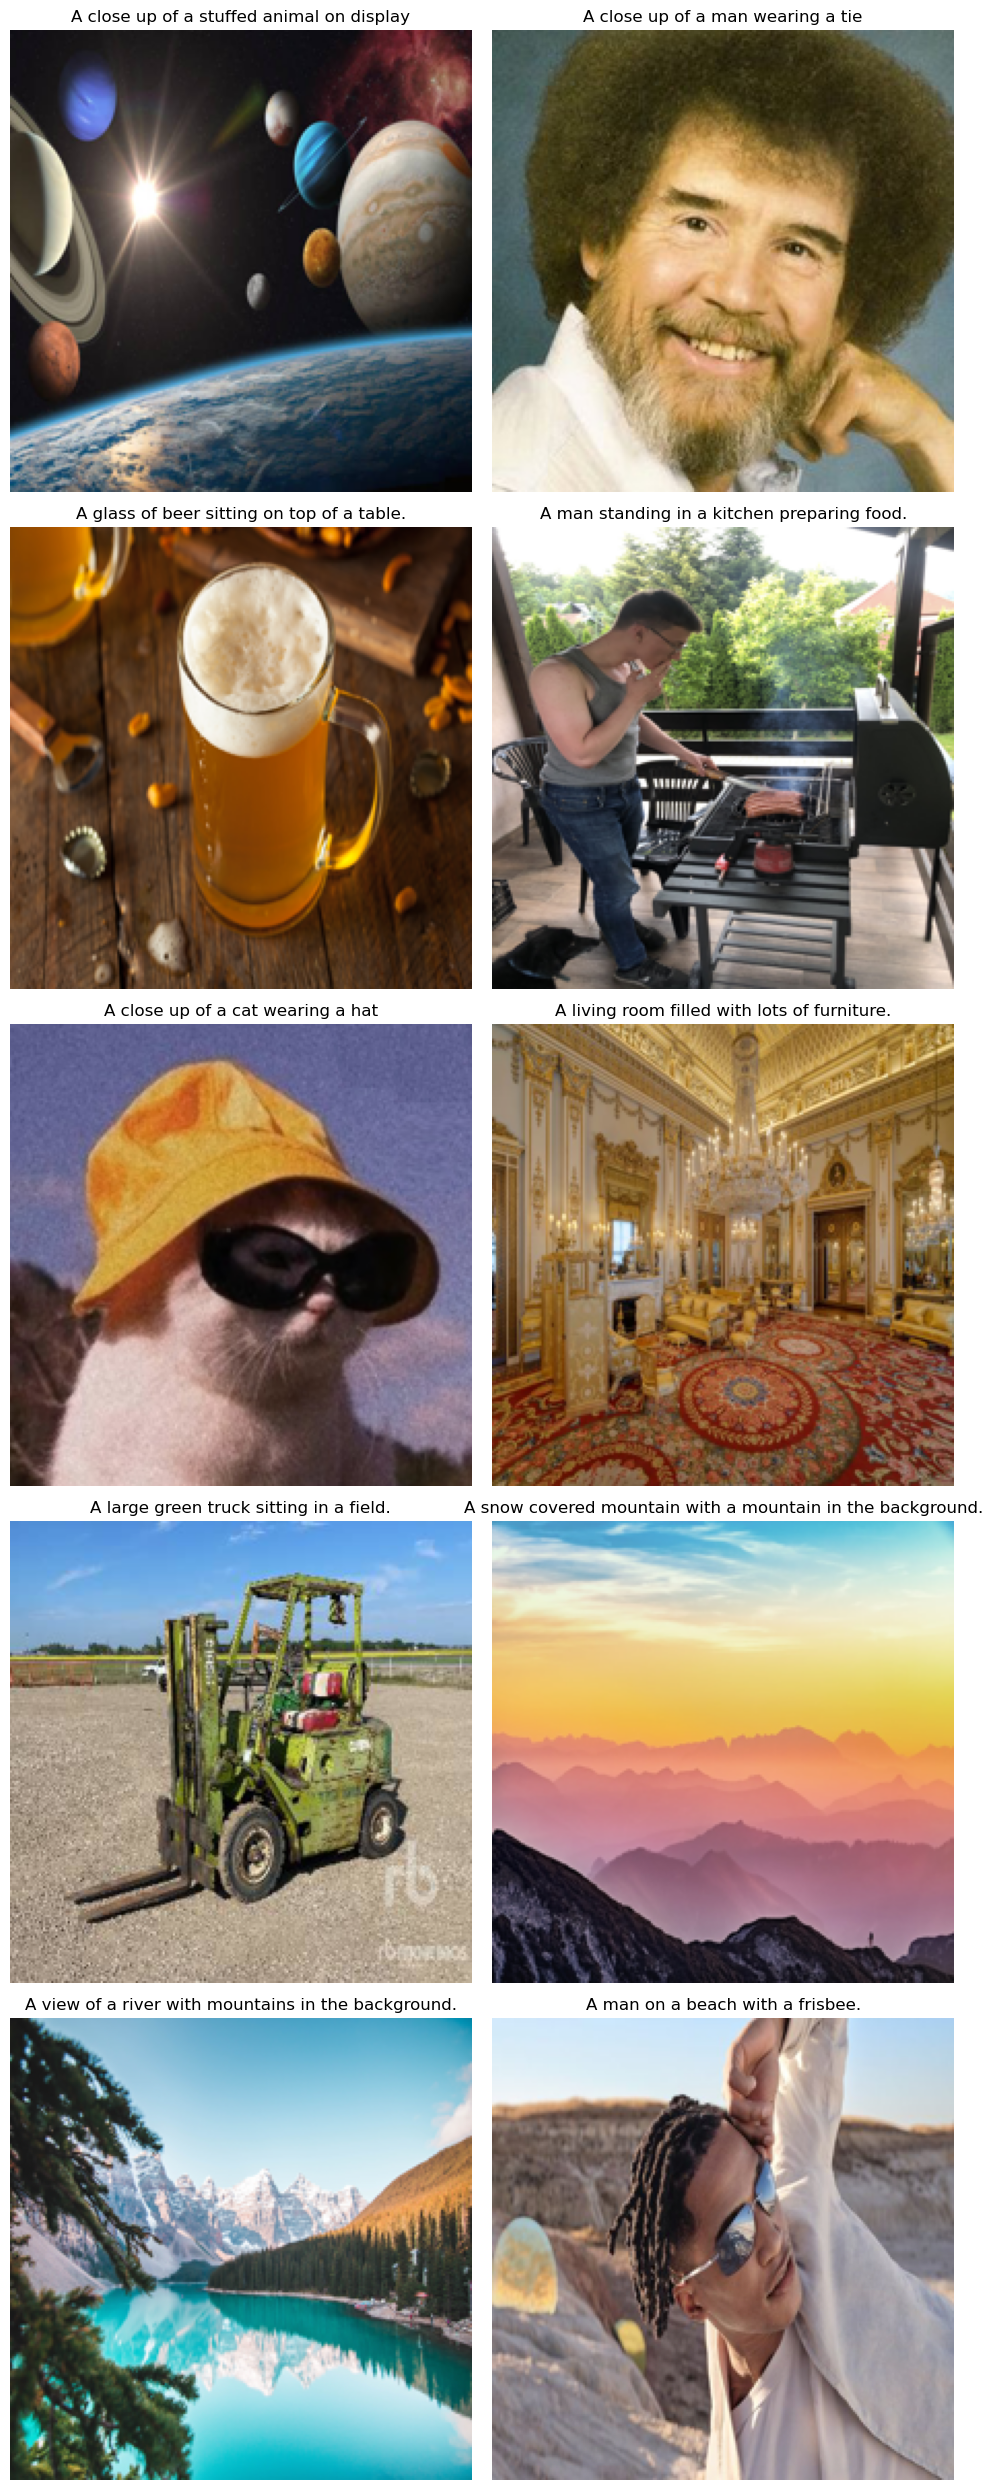

In [4]:
captioner = ImageCaptioner.from_files(
    checkpoint_path="../inference_models/epoch=04-train_loss=2.4821-val_loss=1.8660_ls.ckpt",
    tokenizer_path="../tokenizers/tokenizer-10000.json",
    device="cpu"
)

images = "../test_imgs/"
display_images(images, captioner, beam_size=5, seed=1232)